In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
import mlxtend.classifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [2]:
training_text = pd.read_csv('training_text', sep = "\|\|", engine='python',
                           names = ['ID', 'TEXT'], skiprows = 1)
training_variants = pd.read_csv('training_variants')

In [3]:
training_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
print('No of points in data: ', training_text.shape[0])
print('No of features: ', training_text.shape[1])
print("Name of features: ", training_text.columns.values)

No of points in data:  3321
No of features:  2
Name of features:  ['ID' 'TEXT']


In [5]:
print('No of points in data: ', training_variants.shape[0])
print('No of features: ', training_variants.shape[1])
print("Name of features: ", training_variants.columns.values)

No of points in data:  3321
No of features:  4
Name of features:  ['ID' 'Gene' 'Variation' 'Class']


In [6]:
training_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [7]:
import nltk
# nltk.download()
from nltk.corpus import stopwords
# loading stopwords

stop_words = set(stopwords.words('english'))

In [8]:
import re
def nlp_prepocesssing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        
        #replace every specail character with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        
        #replace multple spaces with single space
        total_text = re.sub('\s+', ' ', total_text)
        
        #convert all char in lower case
        total_text = total_text.lower()
        
        for word in total_text.split():
            #word is not in stopword then store it
            if not word in stop_words:
                string += word + " "
                
        training_text[column][index] = string
                
        

In [9]:
import time
start_time = time.perf_counter() 
  
for index, row in training_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_prepocesssing(row['TEXT'], index, 'TEXT')
    else:
        print("There is no text description for id: ", index)
print("Time took for preproceesing = ", time.perf_counter() -start_time, 'seconds')

There is no text description for id:  1109
There is no text description for id:  1277
There is no text description for id:  1407
There is no text description for id:  1639
There is no text description for id:  2755
Time took for preproceesing =  31.907877099933103 seconds


In [10]:
df_data = pd.merge(training_variants,training_text, how = 'left')
df_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [11]:
df_data.isnull().any()

ID           False
Gene         False
Variation    False
Class        False
TEXT          True
dtype: bool

In [12]:
print("No of null values in TEXT data are :" , df_data['TEXT'].isnull().sum())

No of null values in TEXT data are : 5


In [13]:
df_data[df_data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [14]:
df_data.loc[df_data['TEXT'].isnull(), 'TEXT'] = df_data['Gene'] + ' ' + df_data['Variation']

In [15]:
print("No of null values in TEXT data are :" , df_data['TEXT'].isnull().sum())
df_data[df_data['ID'] == 1277]

No of null values in TEXT data are : 0


,ID,Gene,Variation,Class,TEXT
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations


In [16]:
print("No of null values in TEXT data are :" , df_data['TEXT'].isnull().sum())
df_data[df_data['ID'] == 1276]

No of null values in TEXT data are : 0


,ID,Gene,Variation,Class,TEXT
1276,1276,PIK3R2,S273C,5,demonstrate phosphatidylinositol 3 kinase pi3k...


In [17]:
#splitting dataset in train 8:2
from sklearn.model_selection import train_test_split
y_true = df_data['Class'].values
df_data.gene = df_data.Gene.str.replace('\s+', '_')
df_data.variation = df_data.Variation.str.replace('\s+', '_')

In [18]:
x_train, test_df, y_train, y_test = train_test_split(df_data,y_true, stratify = y_true, test_size=0.2)

train_df, cv_df, y_train, y_cv = train_test_split(x_train,y_train, stratify =y_train, test_size=0.2)

In [19]:
print('No of data points in train data:', train_df.shape[0])
print('No of data points in test data:', test_df.shape[0])
print('No of data points in cross validation data:', cv_df.shape[0])


No of data points in train data: 2124
No of data points in test data: 665
No of data points in cross validation data: 532


In [20]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cross_validation_distribution = cv_df['Class'].value_counts().sort_index()

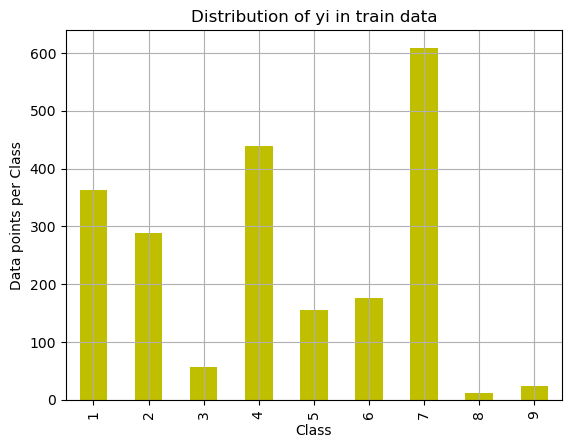

Number of data points in class 7 : 609
Number of data points in class 4 : 439
Number of data points in class 1 : 363
Number of data points in class 2 : 289
Number of data points in class 6 : 176
Number of data points in class 5 : 155
Number of data points in class 3 : 57
Number of data points in class 9 : 24
Number of data points in class 8 : 12


In [21]:
train_class_distribution.plot(kind='bar', color='y')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i] )

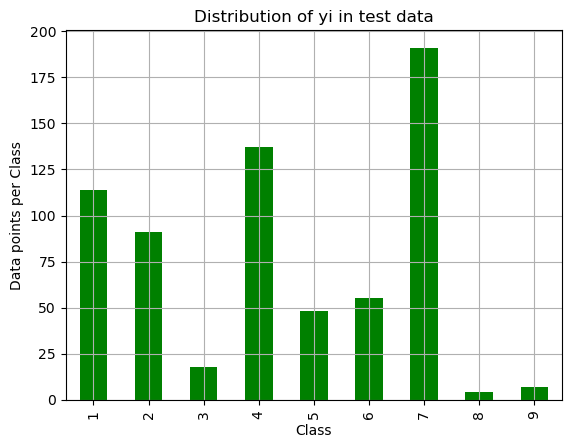

Number of data points in class 7 : 191
Number of data points in class 4 : 137
Number of data points in class 1 : 114
Number of data points in class 2 : 91
Number of data points in class 6 : 55
Number of data points in class 5 : 48
Number of data points in class 3 : 18
Number of data points in class 9 : 7
Number of data points in class 8 : 4


In [22]:
test_class_distribution.plot(kind='bar', color='g')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i] )

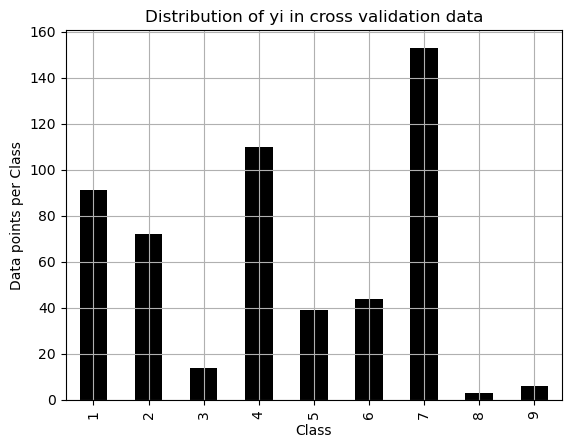

In [23]:
cross_validation_distribution.plot(kind='bar', color='k')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

In [24]:
#Prediction using a 'Random Model'
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =((((C.T)/C.sum(axis=1))).T)
    B = (C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    print("-"*25, "Confusion matrix", "-"*25)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [25]:
#Unvariate Anlaysis
#3.2.1 Gene
unique_genes = train_df['Gene'].value_counts()
print("Number of unique values: ", unique_genes.shape[0])
print(unique_genes.head())

Number of unique values:  234
Gene
BRCA1    151
TP53     112
EGFR      87
PTEN      80
BRCA2     77
Name: count, dtype: int64


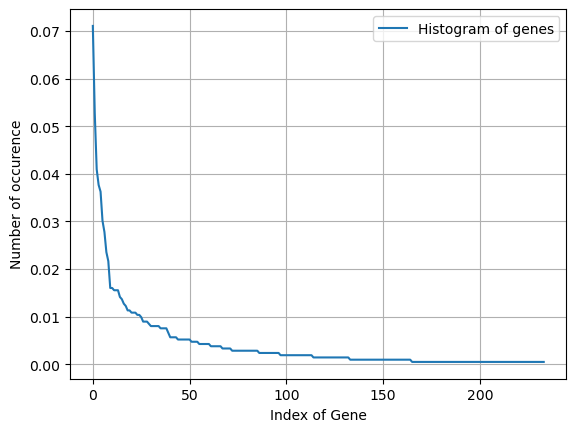

In [26]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label = "Histogram of genes")
plt.xlabel("Index of Gene")
plt.ylabel("Number of occurence")
plt.legend()
plt.grid()
plt.show()

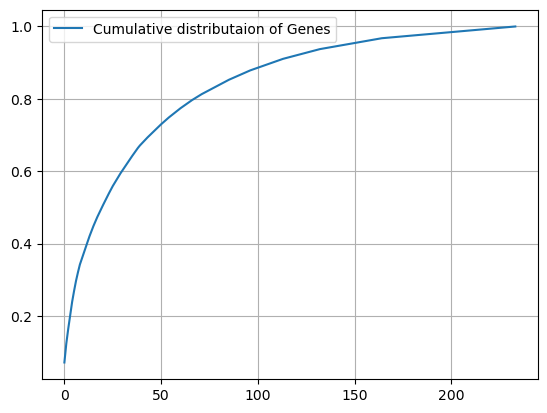

In [27]:
c= np.cumsum(h)
plt.plot(c, label = 'Cumulative distributaion of Genes')
plt.grid()
plt.legend()
plt.show()

In [28]:
# #one hot encoding of gene feature
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [29]:
train_df['Gene'].head()

2842    BRCA2
781     ERBB3
1760     IDH1
739     ERBB2
50      PTPRT
Name: Gene, dtype: object

In [30]:
len(gene_vectorizer.get_feature_names_out())

233

In [31]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", 
                                              train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 233)


In [69]:
import joblib
gene="gene_vector.pkl"
joblib.dump(gene_vectorizer, gene)

['gene_vector.pkl']

In [32]:
#Univariate Analysis on Variation Feature
unique_variations = train_df['Variation'].value_counts()
print("Number of unique Variation: ", unique_variations.shape[0])

Number of unique Variation:  1918


In [33]:
unique_variations.head()

Variation
Truncating Mutations    57
Deletion                54
Amplification           49
Fusions                 26
Overexpression           6
Name: count, dtype: int64

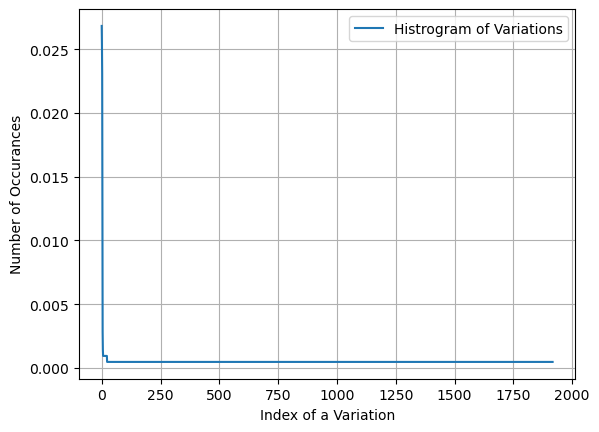

In [34]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02683616 0.05225989 0.07532957 ... 0.99905838 0.99952919 1.        ]


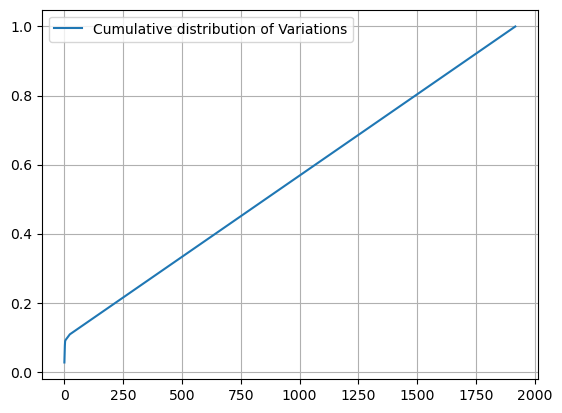

In [35]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [36]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [37]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:",
      train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1946)


In [68]:
import joblib
var="variation_vector.pkl"
joblib.dump(variation_vectorizer, var)

['variation_vector.pkl']

In [38]:
#Univariate Analysis on Text Feature
import collections
def extract_dictionary_paddle(cls_text):
    dictionary = collections.defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [39]:
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52366


In [40]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [41]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [42]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [43]:
print(Counter(sorted_text_occur))

Counter({3: 4805, 4: 3584, 5: 2705, 6: 2697, 8: 2105, 7: 2055, 10: 1663, 9: 1661, 12: 1208, 13: 1068, 11: 1034, 16: 1014, 15: 773, 14: 740, 17: 723, 18: 670, 20: 660, 19: 616, 24: 501, 21: 470, 22: 420, 26: 386, 28: 379, 30: 366, 27: 365, 25: 360, 39: 343, 48: 339, 23: 339, 32: 321, 29: 313, 31: 276, 33: 263, 34: 250, 40: 249, 36: 249, 35: 231, 42: 228, 45: 217, 38: 212, 37: 197, 41: 186, 44: 179, 46: 166, 57: 164, 52: 160, 43: 159, 51: 156, 47: 156, 50: 147, 49: 145, 53: 143, 56: 141, 55: 139, 54: 139, 60: 130, 59: 127, 58: 122, 61: 118, 64: 116, 63: 110, 84: 106, 65: 104, 62: 102, 76: 100, 70: 96, 69: 95, 68: 95, 66: 94, 96: 93, 67: 91, 80: 86, 78: 86, 74: 84, 72: 84, 82: 79, 73: 79, 71: 76, 75: 75, 81: 74, 77: 73, 95: 70, 79: 70, 100: 65, 86: 65, 85: 63, 90: 62, 98: 60, 94: 60, 87: 60, 93: 58, 91: 58, 83: 58, 99: 56, 102: 55, 97: 54, 107: 53, 109: 52, 108: 51, 112: 50, 92: 50, 88: 50, 135: 49, 119: 49, 105: 49, 126: 47, 118: 47, 110: 47, 104: 47, 137: 45, 130: 45, 124: 45, 122: 45, 

In [67]:
import joblib
text="text_vector.pkl"
joblib.dump(text_vectorizer, text)

['text_vector.pkl']

In [44]:
#Machine Learning Models
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [45]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [46]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [47]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54545)
(number of data points * number of features) in test data =  (665, 54545)
(number of data points * number of features) in cross validation data = (532, 54545)


In [48]:
from sklearn.metrics import log_loss


for alpha = 5
Log Loss : 1.234933343502447
for alpha = 11
Log Loss : 1.277633566086132
for alpha = 15
Log Loss : 1.332678149047156
for alpha = 21
Log Loss : 1.4143317103995081
for alpha = 31
Log Loss : 1.4477788687049464
for alpha = 41
Log Loss : 1.4062072108504744
for alpha = 51
Log Loss : 1.3596812741402586
for alpha = 99
Log Loss : 1.4000494221075876


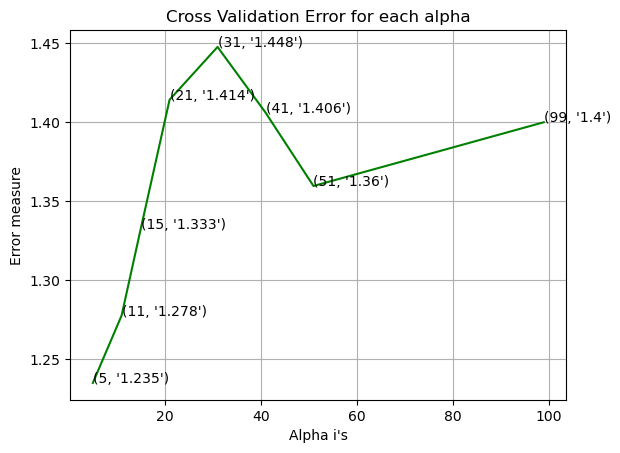

For values of best alpha =  5 The train log loss is: 0.9764398698707347
For values of best alpha =  5 The cross validation log loss is: 1.234933343502447
For values of best alpha =  5 The test log loss is: 1.28890731693553


In [49]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",
                      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",
                                          log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",
                                      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.234933343502447
Number of mis-classified points : 0.3815789473684211
------------------------- Confusion matrix -------------------------


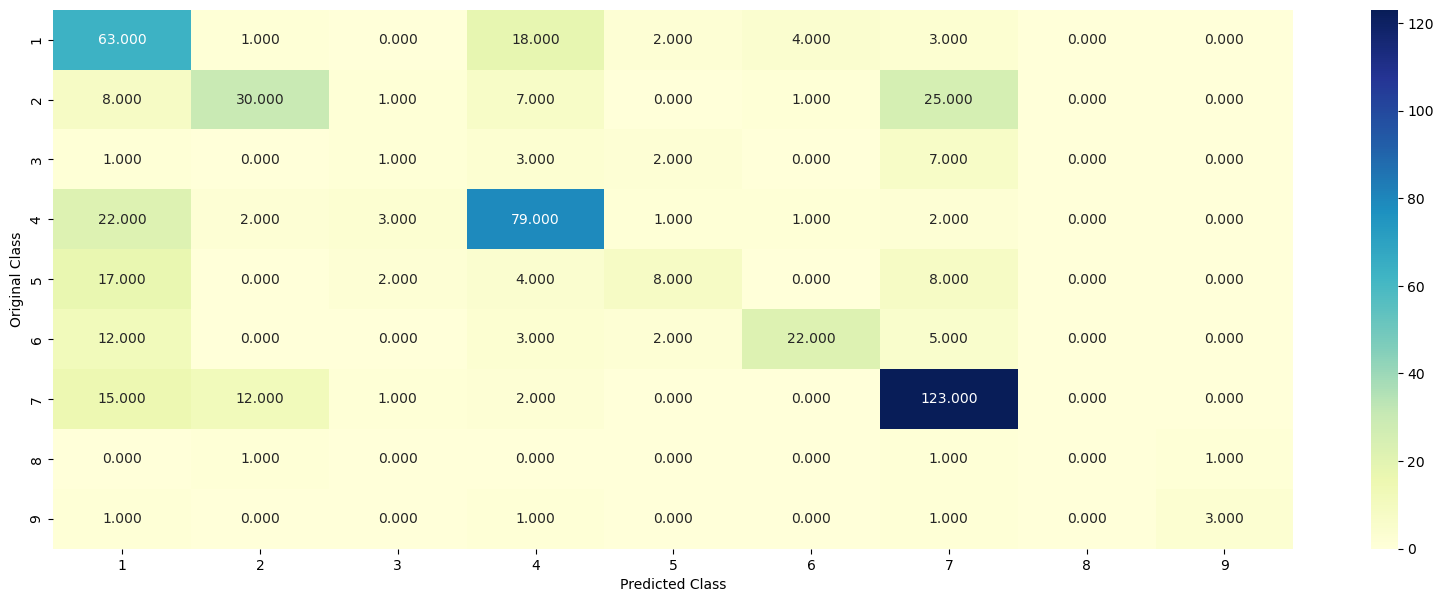

-------------------- Precision matrix (Columm Sum=1) --------------------


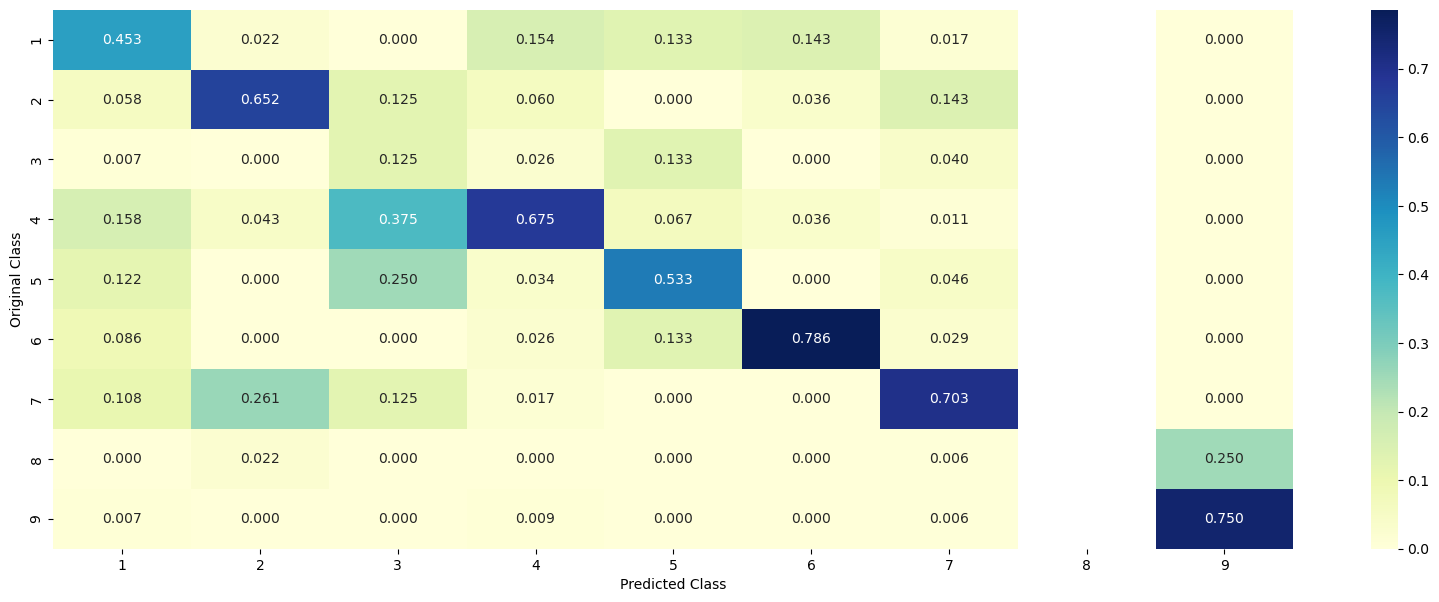

-------------------- Recall matrix (Row sum=1) --------------------


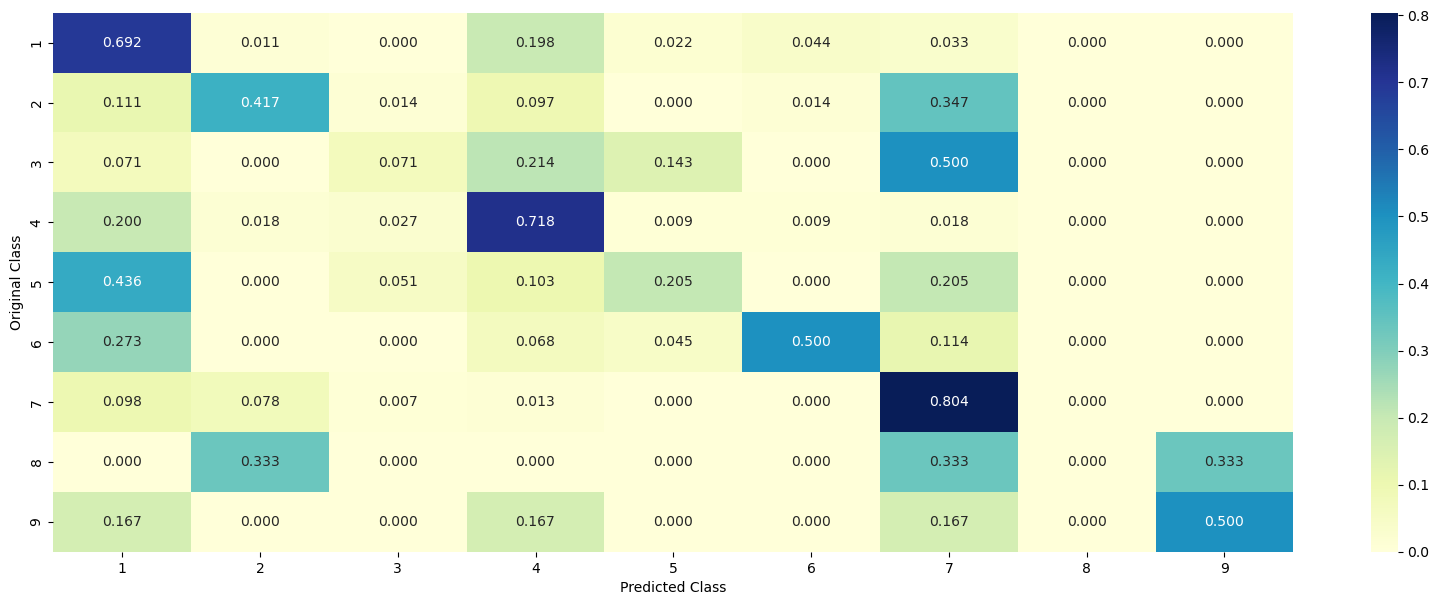

In [50]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [51]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index =100
predicted_cls = sig_clf.predict(test_x_onehotCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_onehotCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 5
Actual Class : 7
The  5  nearest neighbours of the test points belongs to classes [7 7 7 7 7]
Fequency of nearest points : Counter({7: 5})


for alpha = 1e-06
Log Loss : 1.341588054226837
for alpha = 1e-05
Log Loss : 1.3273697446876627
for alpha = 0.0001
Log Loss : 1.264844192225139
for alpha = 0.001
Log Loss : 1.178176655077649
for alpha = 0.01
Log Loss : 1.1418387777789298
for alpha = 0.1
Log Loss : 1.3511804135891146
for alpha = 1
Log Loss : 1.7181105013627571
for alpha = 10
Log Loss : 1.732751459649966
for alpha = 100
Log Loss : 1.7327486241472583


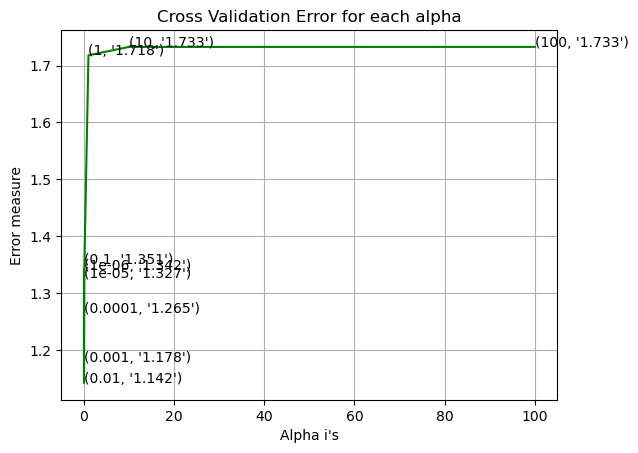

For values of best alpha =  0.01 The train log loss is: 0.7361470713548589
For values of best alpha =  0.01 The cross validation log loss is: 1.1418387777789298
For values of best alpha =  0.01 The test log loss is: 1.0893605730663103


In [52]:
#logistic regression with balance
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",
                                      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",
                                              log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",
                      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1418387777789298
Number of mis-classified points : 0.36466165413533835
------------------------- Confusion matrix -------------------------


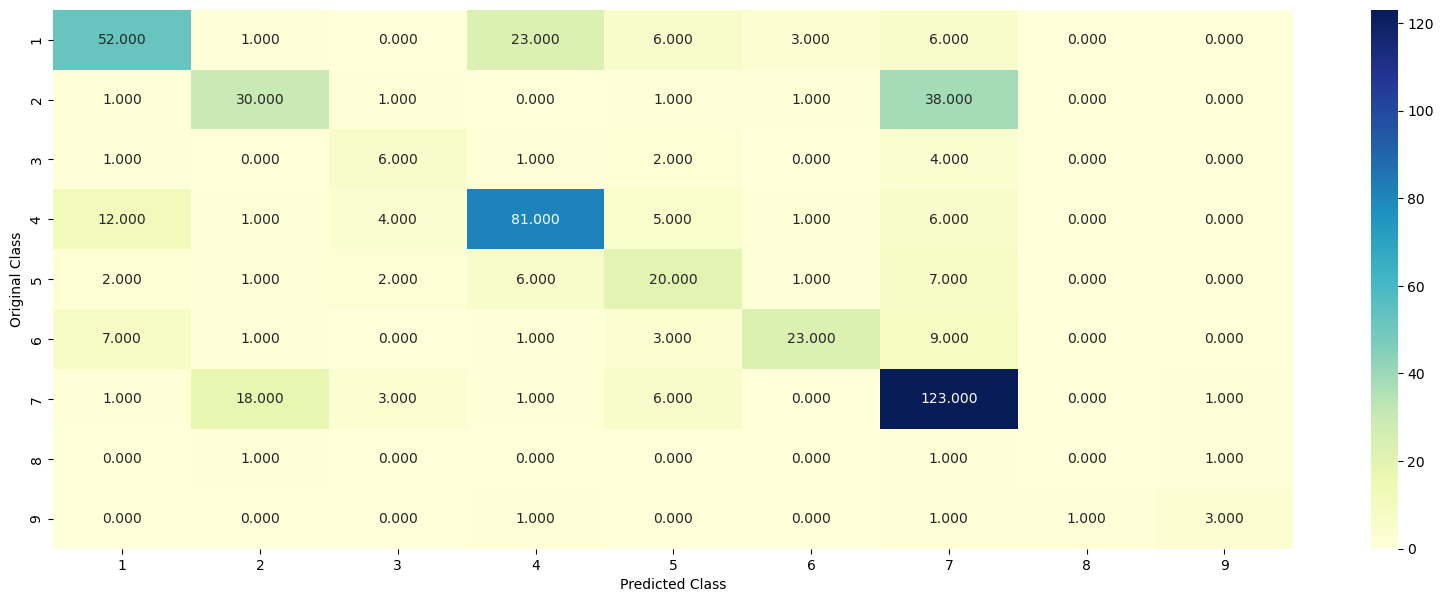

-------------------- Precision matrix (Columm Sum=1) --------------------


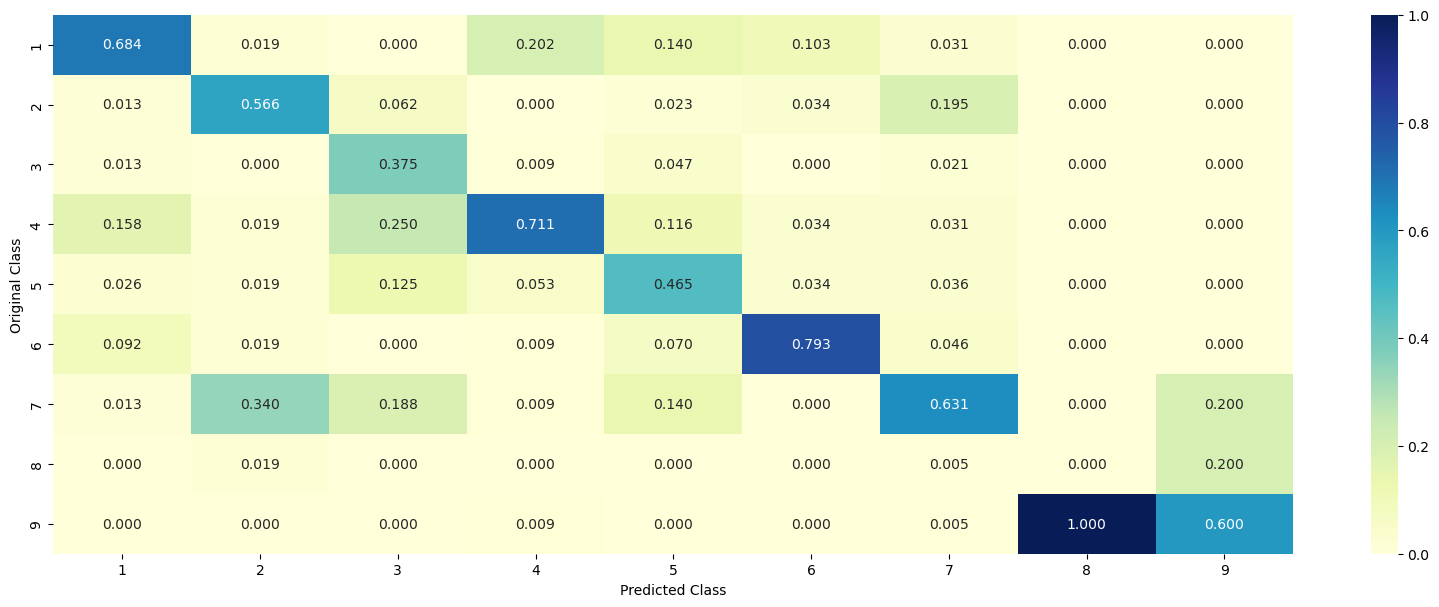

-------------------- Recall matrix (Row sum=1) --------------------


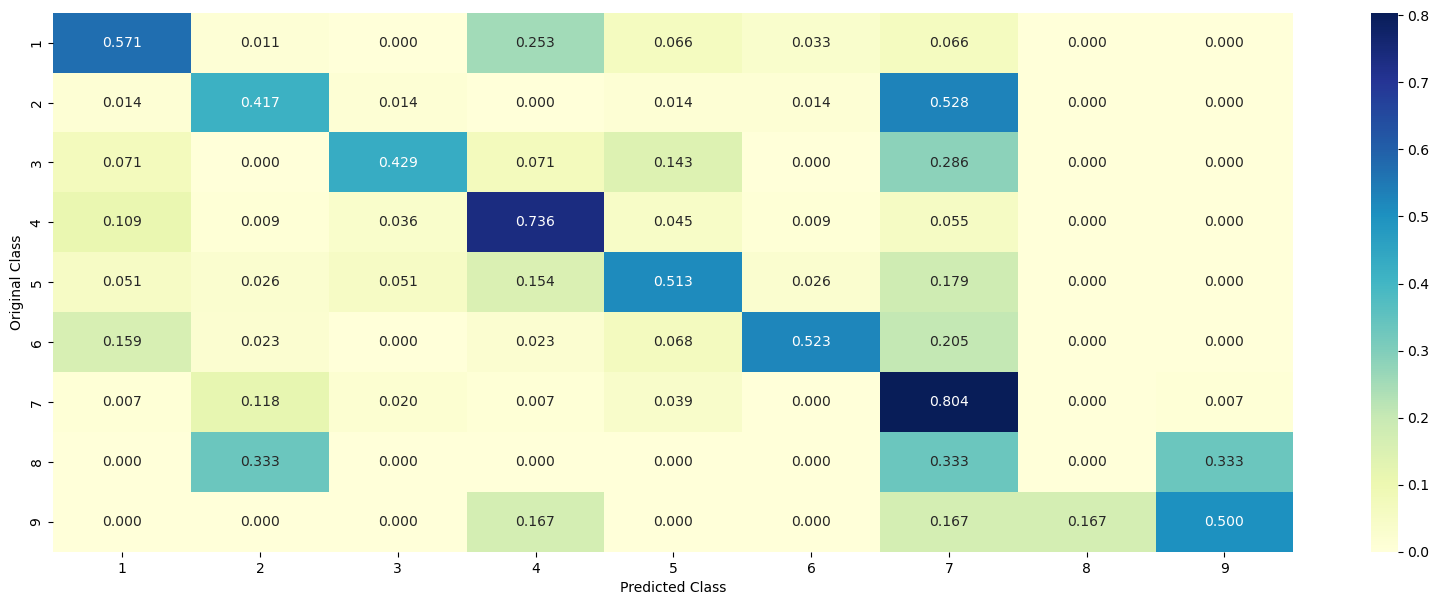

In [53]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

for C = 1e-05
Log Loss : 1.3273697446876627
for C = 0.0001
Log Loss : 1.264844192225139
for C = 0.001
Log Loss : 1.178176655077649
for C = 0.01
Log Loss : 1.1418387777789298
for C = 0.1
Log Loss : 1.3511804135891146
for C = 1
Log Loss : 1.7181105013627571
for C = 10
Log Loss : 1.732751459649966
for C = 100
Log Loss : 1.7327486241472583


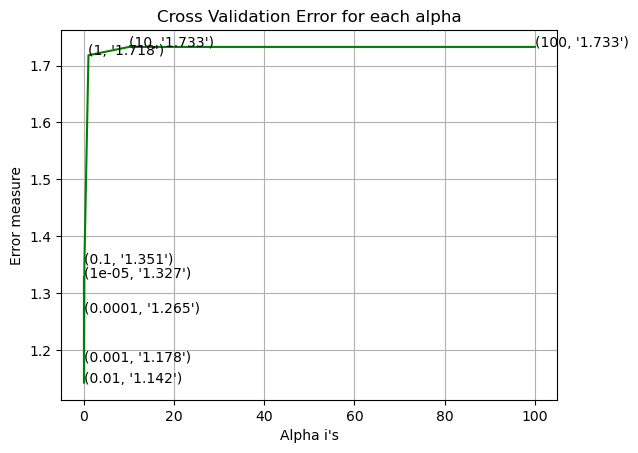

For values of best alpha =  0.01 The train log loss is: 0.7361470713548589
For values of best alpha =  0.01 The cross validation log loss is: 1.1418387777789298
For values of best alpha =  0.01 The test log loss is: 1.0893605730663103


In [54]:
#SVM

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",
                                      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",
                                              log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",
                                      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1418387777789298
Number of mis-classified points : 0.36466165413533835
------------------------- Confusion matrix -------------------------


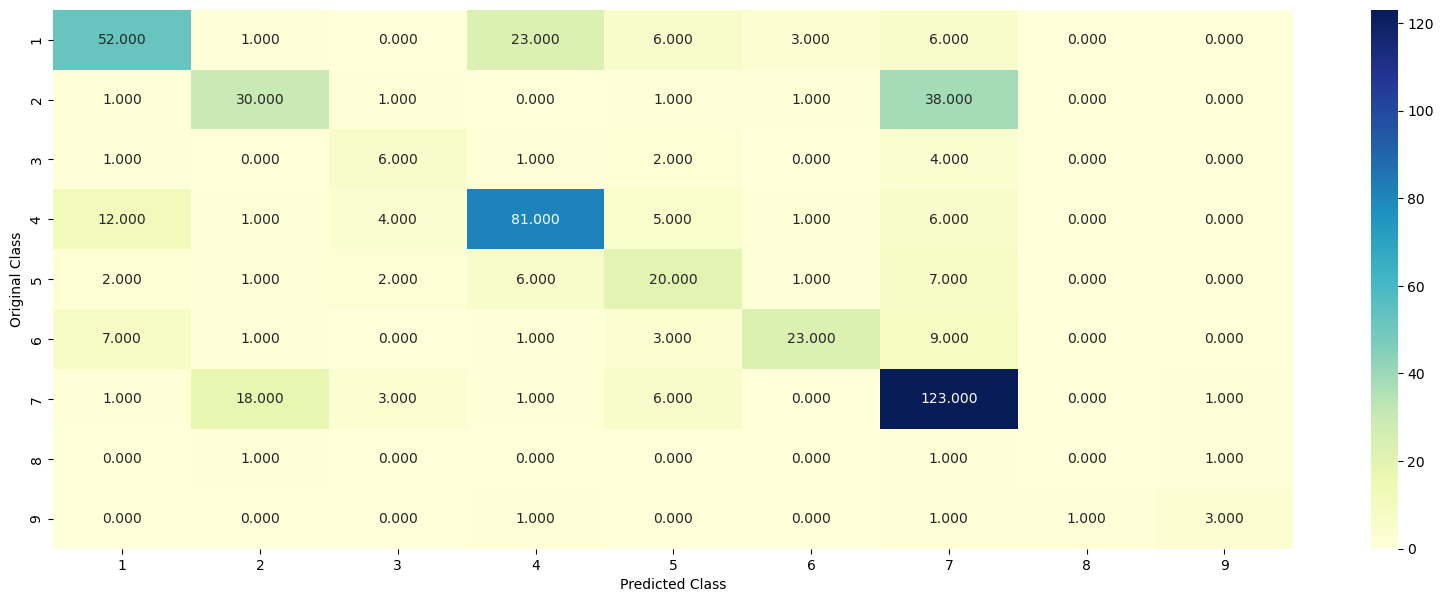

-------------------- Precision matrix (Columm Sum=1) --------------------


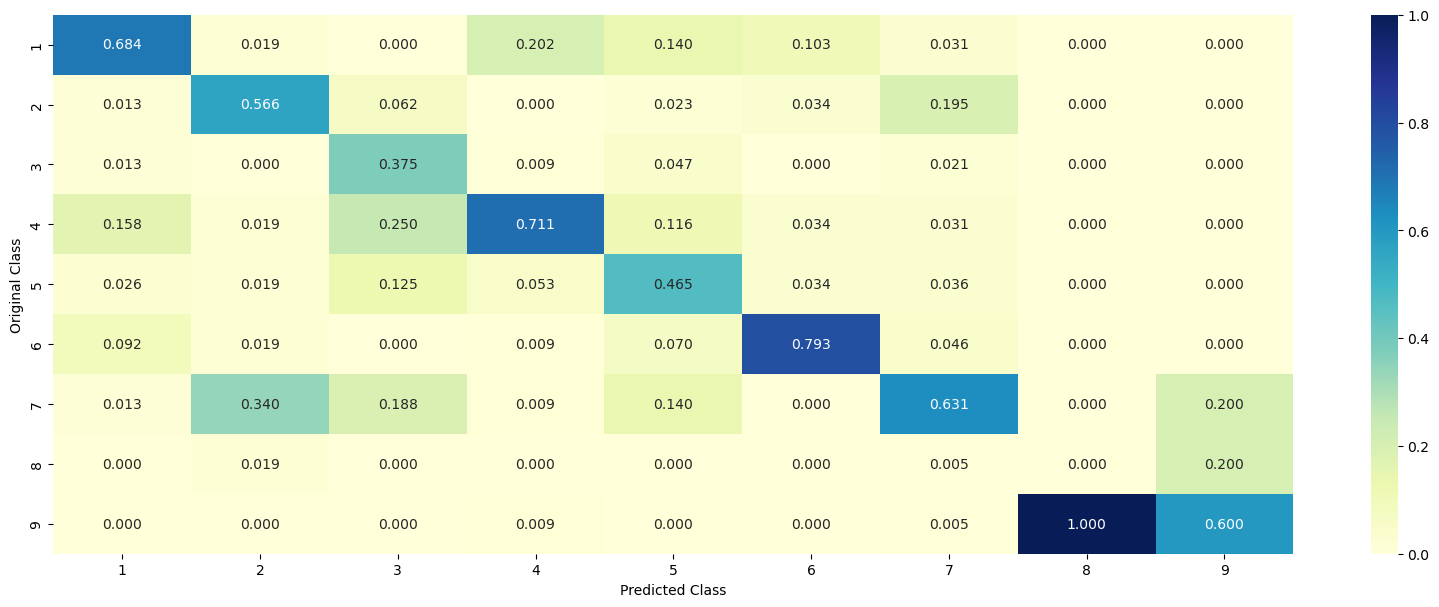

-------------------- Recall matrix (Row sum=1) --------------------


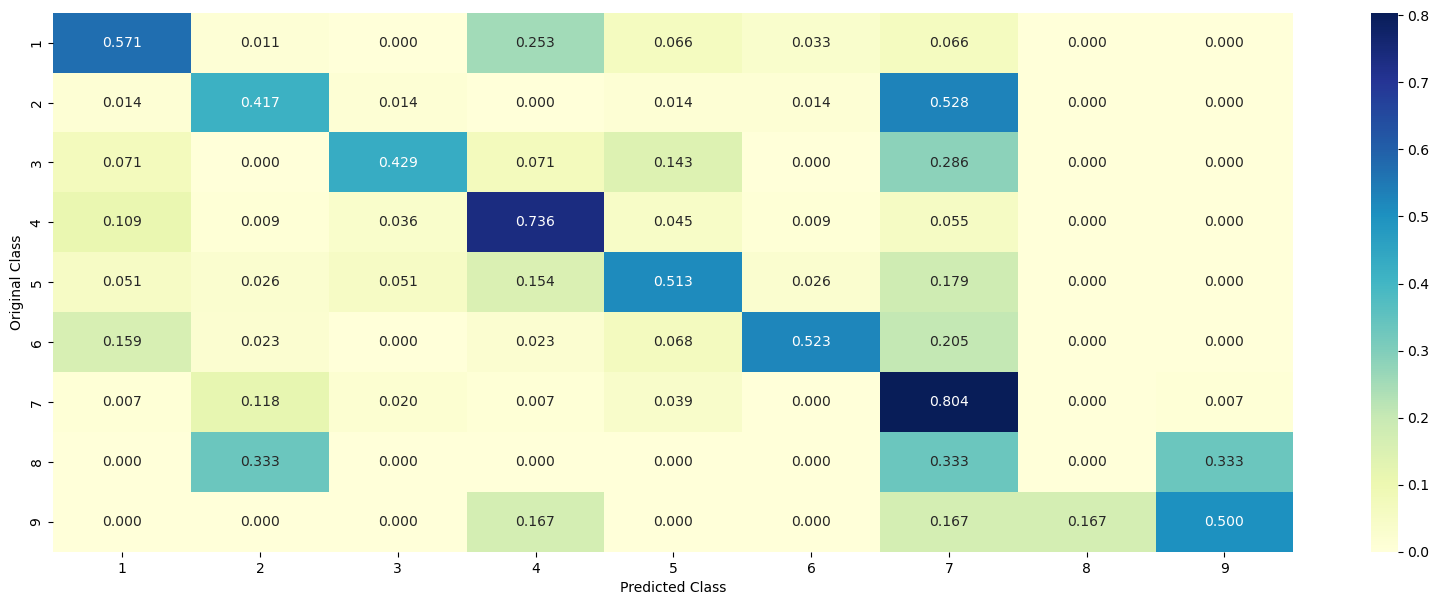

In [55]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [64]:
clf1 = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf1.fit(train_x_onehotCoding,train_y)
test_point_index = 100
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(abs(-clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 7
Predicted Class Probabilities: [[0.0368 0.0515 0.0084 0.0206 0.0259 0.0098 0.8424 0.0026 0.002 ]]
Actual Class : 7
--------------------------------------------------


In [70]:
import joblib
model="svm_model.pkl"
joblib.dump(clf1, model)

['svm_model.pkl']

In [3]:
import joblib
import scipy.sparse

# Load the trained model
model = joblib.load('svm_model.pkl')

# Load the CountVectorizers for each feature
gene_vectorizer = joblib.load('gene_vector.pkl')
variation_vectorizer = joblib.load('variation_vector.pkl')
text_vectorizer = joblib.load('text_vector.pkl')

# Get user input for gene, variation, and text
gene = input('Enter the gene: ')
variation = input('Enter the variation: ')
text = input('Enter the text: ')

# Preprocess the user input using the corresponding CountVectorizers
gene_vector = gene_vectorizer.transform([gene])
variation_vector = variation_vectorizer.transform([variation])
text_vector = text_vectorizer.transform([text])

# Concatenate the preprocessed vectors into a single input vector
input_vector = scipy.sparse.hstack((gene_vector, variation_vector, text_vector))

# Make predictions using the preprocessed input
prediction = model.predict(input_vector)

print('Predicted class:', prediction)

Enter the gene: FAM58A
Enter the variation: Truncating Mutations
Enter the text: FAM58A Truncating Mutations
Predicted class: [1]
